In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyximport
import h5py
from tqdm import tqdm

pyximport.install(setup_args={'include_dirs': np.get_include()},reload_support=True)
from RigidWall_InertialLangevin3D_cython import RigidWallInertialLangevin3D

from mpl_toolkits import mplot3d
from scipy.signal import correlate

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 140

mpl.rcParams["xtick.direction"] = "in"
mpl.rcParams["ytick.direction"] = "in"
mpl.rcParams["lines.markeredgecolor"] = "k"
mpl.rcParams["lines.markeredgewidth"] = 0.1
mpl.rcParams["figure.dpi"] = 130
from matplotlib import rc
rc('font', family='serif')
#rc('text', usetex=True)
rc('xtick', labelsize='x-small')
rc('ytick', labelsize='x-small')

In [2]:
class HDF5Store(object):
    """
    Simple class to append value to a hdf5 file on disc (usefull for building keras datasets)
    
    Params:
        datapath: filepath of h5 file
        dataset: dataset name within the file
        shape: dataset shape (not counting main/batch axis)
        dtype: numpy dtype
    
    Usage:
        hdf5_store = HDF5Store('/tmp/hdf5_store.h5','X', shape=(20,20,3))
        x = np.random.random(hdf5_store.shape)
        hdf5_store.append(x)
        hdf5_store.append(x)
        
    From https://gist.github.com/wassname/a0a75f133831eed1113d052c67cf8633
    """
    def __init__(self, datapath, dataset, shape, dtype=np.float64, compression="gzip", chunk_len=1):
        self.datapath = datapath
        self.dataset = dataset
        self.shape = shape
        self.i = 0
        
        with h5py.File(self.datapath, mode='w') as h5f:
            self.dset = h5f.create_dataset(
                dataset,
                shape=(0, ) + shape,
                maxshape=(None, ) + shape,
                dtype=dtype,
                compression=compression,
                chunks=(chunk_len, ) + shape)
    
    def append(self, values): #ajoute au fichier
        with h5py.File(self.datapath, mode='a') as h5f:
            dset = h5f[self.dataset]
            dset.resize((self.i + 1, ) + self.shape)
            dset[self.i] = [values]
            self.i += 1
            h5f.flush()

In [3]:
langevin3D = RigidWallInertialLangevin3D(dt=1e-8, Nt=10000000, R=1.5e-6, rho=1050, x0=(0., 0., 1.5e-6))

In [4]:
langevin3D.trajectory()   #%timeit 

# il faut enregistrer les 10 000 000 premiers points entièrement pour les temps courts
tmp_short = langevin3D.x, langevin3D.y, langevin3D.z, langevin3D.t

In [5]:
# store_full = HDF5Store("Datas_inertial_RIgidWall\inertial_simulation_rigid_rigid_wall_r1p5em6_rho1050_B4_ld_70em9_dt1em7full_dt1em2reduced_10kpoints.h5", "full_data_1run", shape = (3, 10000000))

#store_full.append([langevin3D.x, langevin3D.y, langevin3D.z])


In [6]:
# store_reduced = HDF5Store("Datas_inertial_RIgidWall\inertial_simulation_rigid_rigid_wall_r1p5em6_rho1050_B4_ld_70em9_dt1em7full_dt1em2reduced_10kpoints.h5", "reduced_data_1run", shape = (3,9999990))

tmp = np.zeros((4,9999990))


In [7]:
for i in tqdm(range(15)):  #10010
    langevin3D.x0 = np.array([langevin3D.x[-2:],langevin3D.y[-2:],langevin3D.z[-2:]])
    
    langevin3D.trajectory()
    tmp[:,i*999:i*999+999] = np.array((langevin3D.x,langevin3D.y,langevin3D.z, langevin3D.t))[:,::10000][:,1:]
    
    

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:54<00:00,  7.63s/it]


In [8]:
# store_reduced.append(tmp)

In [9]:
non_zero = np.nonzero(tmp)
last = non_zero[1][-1]
last

14984

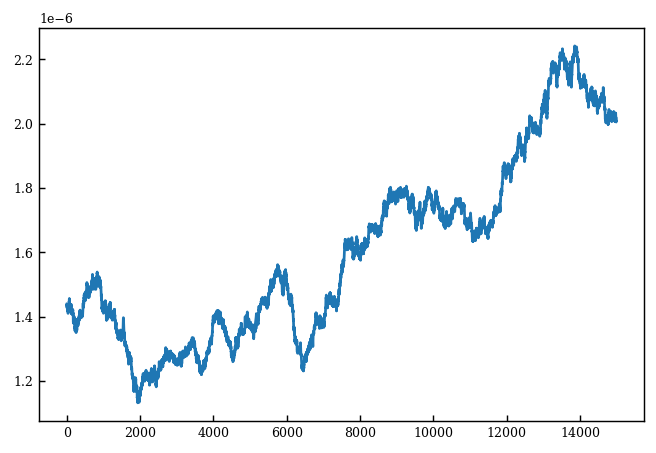

In [10]:
plt.plot(tmp[2,:last])

In [11]:
dt = langevin3D.dt
tmp_long = tmp[0,:last], tmp[1,:last], tmp[2,:last], tmp[3,:last] # t = np.linspace(0, last*dt,last)

# Rasemblement temps court et long
x = np.concatenate((tmp_short[0], tmp_long[0]))
y = np.concatenate((tmp_short[1], tmp_long[1]))
z = np.concatenate((tmp_short[2], tmp_long[2]))
t = np.concatenate((tmp_short[3], tmp_long[3]))
len(x), len(y), len(z), len(t)

(10014984, 10014984, 10014984, 10014984)

C:\Users\Shadow\Anaconda3\envs\these\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


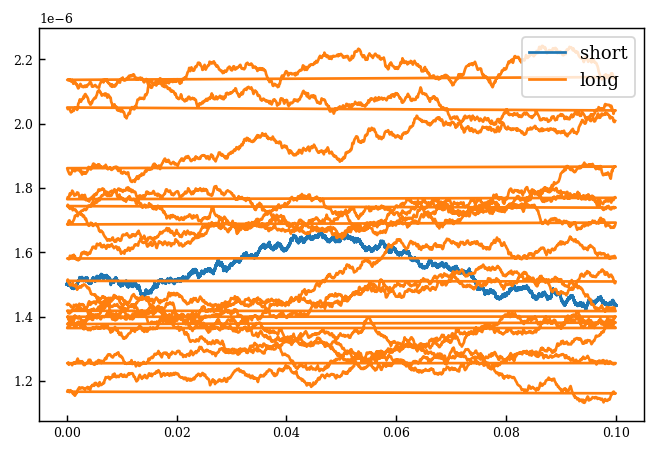

In [12]:
plt.plot(tmp_short[3], (tmp_short[2]), label="short")
plt.plot( tmp_long[3],  tmp_long[2], label="long") # z(t)
plt.legend()

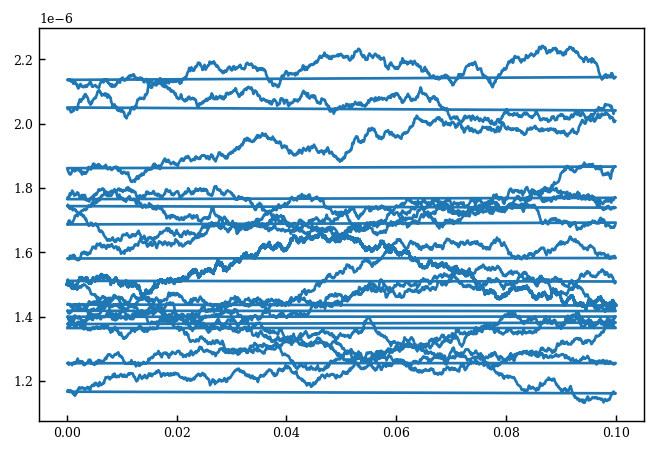

In [13]:
plt.plot(t, z)

In [14]:
### CALCUL MSD fonction
def MSD1D(data, axis="z"):
    
    #construction de la liste de dt (10 points / décade)
    list_dt_MSD = np.array([]) #, dtype=np.int
    
    for i,_ in enumerate(str(len(data))[:-1]):
        # Take just 10 points by decade.
        list_dt_MSD = np.concatenate(
            (
                list_dt_MSD,
                np.arange(10 ** i, 10 ** (i + 1), 10 ** i)
            )
        )
        
    #calcul MSD
    NumberOfMSDPoint = len(list_dt_MSD)
    MSD = np.zeros(NumberOfMSDPoint)
    for n, i in enumerate(list_dt_MSD.astype(np.int)):
        if i == 0:
            MSD[n] = 0
            continue
        MSD[n] = np.mean((data[i:] - data[0:-i]) ** 2)
        
    return list_dt_MSD, MSD
        

In [15]:
dt_MSD, MSD1D = MSD1D(z)
# list_dt_MSD = MSD1D(z)[0]

In [16]:
new_dt = langevin3D.dt * 10000 # vue qu'on prend 1 point tout les 10 000 vrai points, alors new_dt = dt * 10 000 !
new_dt, dt_MSD



(0.0001,
 array([1.e+00, 2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00,
        9.e+00, 1.e+01, 2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01,
        8.e+01, 9.e+01, 1.e+02, 2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02,
        7.e+02, 8.e+02, 9.e+02, 1.e+03, 2.e+03, 3.e+03, 4.e+03, 5.e+03,
        6.e+03, 7.e+03, 8.e+03, 9.e+03, 1.e+04, 2.e+04, 3.e+04, 4.e+04,
        5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04, 1.e+05, 2.e+05, 3.e+05,
        4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05, 1.e+06, 2.e+06,
        3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06]))

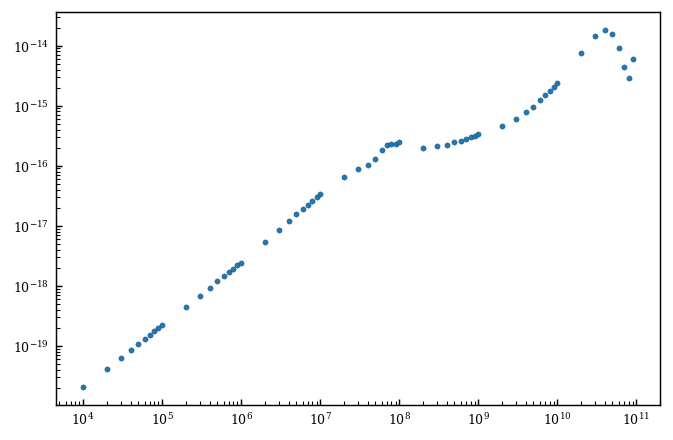

In [17]:
plt.loglog(dt_MSD/new_dt, MSD1D, ".")